**UAS DEEP LEARNING**

Nama: Nur Fajar - NPM: 187006102

In [94]:
import os
import pandas as pd
import tensorflow as tf
import shutil
import glob

import warnings
warnings.filterwarnings("ignore")

1. Load Data

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset = '/content/drive/My Drive/Dataset_UAS'

In [6]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(dataset):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [8]:
# memunculkan jumlah data dengan susunan berdasarkan tag
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
A    105
B     61
C    127
D     18
dtype: int64

In [9]:
df.head()

,path,file_name,tag
0,/content/drive/My Drive/Dataset_UAS/A/336.png,336.png,A
1,/content/drive/My Drive/Dataset_UAS/A/274.png,274.png,A
2,/content/drive/My Drive/Dataset_UAS/A/207.png,207.png,A
3,/content/drive/My Drive/Dataset_UAS/A/352.png,352.png,A
4,/content/drive/My Drive/Dataset_UAS/A/50_.png,50_.png,A


2. Data Preprocessing


In [10]:
#library yang digunakan untuk split data
from sklearn.model_selection import train_test_split

In [11]:
#variabel yang digunakan pada split data
X= df['path']
y= df['tag']

In [52]:
# split dataset awal menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=300)

# kemudian data test dibagi menjadi 2 sehingga menjadi data test dan data validation
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.20, random_state=100)

In [53]:
df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [54]:
print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 248
val size 50
test size 13


In [90]:
# melihat jumlah data pada masing masing jenis data (train, validatio, test)
df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\

print(df_all.groupby(['set','tag']).size(),'\n')


set         tag
test        A       21
            B       11
            C       15
            D        3
train       A       80
            B       46
            C      108
            D       14
validation  A        4
            B        4
            C        4
            D        1
dtype: int64 



In [56]:
import shutil
from tqdm.notebook import tqdm as tq

In [57]:
datasource_path = '/content/drive/My Drive/Dataset_UAS'
dataset_path = "dataset_cnn/"

In [58]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [60]:
# Define Input Parameters
dim = (150, 150)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [91]:
train_generator = train_datagen.flow_from_directory('dataset_cnn/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset_cnn/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset_cnn/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 248 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [64]:
print(labels)

dict_keys(['A', 'B', 'C', 'D'])


In [65]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [66]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

3. Membangun Arsitektur CNN

In [67]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

In [68]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 128)     3584      
                                                                 
 activation_6 (Activation)   (None, 150, 150, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      36896     
                                                                 
 activation_7 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                      

In [70]:
from tensorflow.keras.applications import MobileNetV2

# get base models
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

In [71]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 128)     3584      
                                                                 
 activation_6 (Activation)   (None, 150, 150, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      36896     
                                                                 
 activation_7 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                      

In [73]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [34]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 50 kB 2.9 MB/s 


In [74]:
from efficientnet.tfkeras import EfficientNetB1

In [75]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

In [37]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [76]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [77]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 32)   864         ['input_4[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 75, 75, 32)   0           ['stem_bn[0][0]']          

In [78]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


4. Train Model

In [81]:
EPOCH = 5
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 1/5
16/16 [==============================] - 69s 3s/step - loss: 1.0837 - accuracy: 0.5806 - val_loss: 1.3392 - val_accuracy: 0.4375
Epoch 2/5
16/16 [==============================] - 49s 3s/step - loss: 0.4527 - accuracy: 0.8306 - val_loss: 1.8895 - val_accuracy: 0.3750
Epoch 3/5
16/16 [==============================] - 50s 3s/step - loss: 0.3622 - accuracy: 0.8750 - val_loss: 1.6841 - val_accuracy: 0.5625
Epoch 4/5
16/16 [==============================] - 47s 3s/step - loss: 0.2532 - accuracy: 0.9073 - val_loss: 1.1797 - val_accuracy: 0.6250
Epoch 5/5
16/16 [==============================] - 47s 3s/step - loss: 0.1651 - accuracy: 0.9556 - val_loss: 0.8554 - val_accuracy: 0.8125


In [82]:
history.history['loss']

[1.0837395191192627,
 0.452663779258728,
 0.3622475564479828,
 0.25315165519714355,
 0.1651039868593216]

In [83]:
history.history['accuracy']

[0.5806451439857483,
 0.8306451439857483,
 0.875,
 0.9072580933570862,
 0.9556451439857483]

5. Evaluation

In [84]:
from matplotlib import pyplot as plt

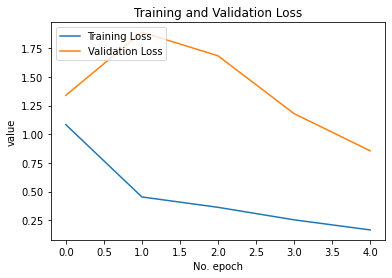

In [85]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

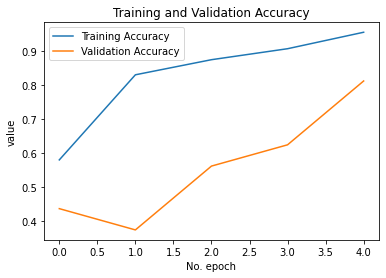

In [86]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [87]:
import os

In [88]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)    
    

Saving Model At model/medium_project/model.h5...


In [89]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n') 

Accuracy on training data: 0.8200 
Loss on training data: 0.6790 

Accuracy on test data: 0.7200 
Loss on test data: 0.9481 

